A well known issue with Sentinel-1 frames as they are distributed is that they are not consistent in time. A fixed-size frame can move along track North or South. This makes time-series enumeration of SLCs for interferograms more complciated.

This notebook takes us through  making the Sentinel-1 "fixed-frames" (or here just "frames") derived from the burst footprints. Bursts are fixed footprints that represent imaging area of the Sentinel-1 IW-mode SAR. The burst map data has generated huge excitement because they represent fixed gegraphic areas through time. The frames that we are defining are a self-imposed organization scheme to allow us to perform large regional scale time-series analysis at roughly the scale of the originally distributed ESA frames.

The burst maps are downloaded from ESA [page](https://sar-mpc.eu/test-data-sets/). We downloaded `S1_burstid_20220530`.

There is some discussion about the metadata found in this table the next notebook. Here, we jumping right to do it to take each burst (across all three swaths) and collect them into a group of 10 within a "frame" so that each frame has a 2 burst overlap. Of course, the number of bursts within a frame and of overlapping neighboring frames could easily be re-configured here. These are based on the approximate size of frames as they are currently distributed via ESA.

**Update**: this utilizes dask to demonstrate some slight speedup. To utilize dask, we have to ensure that one built-in operation per column is used. Therefore, we have to copy columns that we want the min/max of. This extra book-keeping is annoying but shows an approximately 3-4x speedup for the dissolve.

In [1]:
import sqlite3
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
from rasterio.crs import CRS
import warnings

/var/folders/s6/fbsc26cd0ddffbp3_knts_9c0wcxj1/T/ipykernel_28768/1100787639.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


# Parameters

In [2]:
N_BURSTS_PER_FRAME = 8
N_BURSTS_PER_OVERLAP = 1

# Read Burst Data

The data needs to be unzipped first in this directory.

In [3]:
%%time

# SQL must wrap the geometry in hex(st_asbinary(...))
sql = "SELECT * FROM burst_id_map;"
con = sqlite3.connect("S1_burstid_20220530/IW/sqlite/burst_map_IW_000001_375887.sqlite3")

df_burst = gpd.GeoDataFrame.from_postgis(sql, con, geom_col="GEOMETRY")

CPU times: user 8.95 s, sys: 991 ms, total: 9.94 s
Wall time: 10 s


In [4]:
df_burst['relative_orbit_number_min'] = df_burst['relative_orbit_number']
df_burst['relative_orbit_number_max'] = df_burst['relative_orbit_number']
df_burst['OGC_FID_min'] = df_burst['OGC_FID']
df_burst['OGC_FID_max'] = df_burst['OGC_FID']
df_burst.head()

,OGC_FID,GEOMETRY,burst_id,subswath_name,relative_orbit_number,time_from_anx_sec,orbit_pass,relative_orbit_number_min,relative_orbit_number_max,OGC_FID_min,OGC_FID_max
0,1,"MULTIPOLYGON Z (((3.36758 0.75322 0.00000, 3.7...",1,IW1,1,2.301015,ASCENDING,1,1,1,1
1,2,"MULTIPOLYGON Z (((4.09178 0.97402 0.00000, 4.5...",1,IW2,1,3.133218,ASCENDING,1,1,2,2
2,3,"MULTIPOLYGON Z (((4.85545 1.19200 0.00000, 5.2...",1,IW3,1,4.211255,ASCENDING,1,1,3,3
3,4,"MULTIPOLYGON Z (((3.33269 0.92005 0.00000, 3.7...",2,IW1,1,5.059288,ASCENDING,1,1,4,4
4,5,"MULTIPOLYGON Z (((4.05690 1.14071 0.00000, 4.4...",2,IW2,1,5.891491,ASCENDING,1,1,5,5


# Burst Aggregation

Each burst covers three swaths. So we want to merge these bursts together as a single geometric object.

<AxesSubplot: >

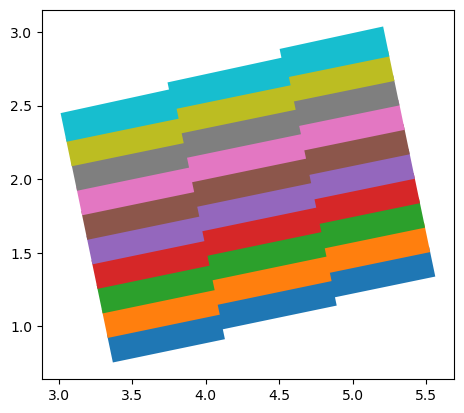

In [5]:
df_burst.head(30).plot(column='burst_id', categorical=True)

In [6]:
%%time

df_burst_triplet_temp = df_burst.dissolve(by='burst_id', 
                                          aggfunc={'OGC_FID_min': 'min',
                                                   'OGC_FID_max': 'max',
                                                   'relative_orbit_number_min': 'min',
                                                   'relative_orbit_number_max': 'max',
                                                   'orbit_pass': 'first'}, 
                                          as_index=False)

CPU times: user 57.4 s, sys: 615 ms, total: 58.1 s
Wall time: 56.8 s


We keep store this as an alternative dataframe because we want to rename columns.

In [7]:
df_burst_triplet_temp.head()

,burst_id,GEOMETRY,OGC_FID_min,OGC_FID_max,relative_orbit_number_min,relative_orbit_number_max,orbit_pass
0,1,"POLYGON Z ((4.12960 0.91167 0.00000, 3.76300 0...",1,3,1,1,ASCENDING
1,2,"POLYGON Z ((4.09471 1.07835 0.00000, 3.72810 1...",4,6,1,1,ASCENDING
2,3,"POLYGON Z ((4.05984 1.24503 0.00000, 3.69323 1...",7,9,1,1,ASCENDING
3,4,"POLYGON Z ((4.02501 1.41172 0.00000, 3.65839 1...",10,12,1,1,ASCENDING
4,5,"POLYGON Z ((3.99020 1.57841 0.00000, 3.62357 1...",13,15,1,1,ASCENDING


In [8]:
df_burst_triplet = df_burst_triplet_temp.reset_index(drop=True)
df_burst_triplet.columns = ['burst_id', 
                            'geometry', 
                            'OGC_FID_min', 
                            'OGC_FID_max', 
                            'relative_orbit_number_min',
                            'relative_orbit_number_max', 
                            'orbit_direction']
df_burst_triplet.head()

,burst_id,geometry,OGC_FID_min,OGC_FID_max,relative_orbit_number_min,relative_orbit_number_max,orbit_direction
0,1,"POLYGON Z ((4.12960 0.91167 0.00000, 3.76300 0...",1,3,1,1,ASCENDING
1,2,"POLYGON Z ((4.09471 1.07835 0.00000, 3.72810 1...",4,6,1,1,ASCENDING
2,3,"POLYGON Z ((4.05984 1.24503 0.00000, 3.69323 1...",7,9,1,1,ASCENDING
3,4,"POLYGON Z ((4.02501 1.41172 0.00000, 3.65839 1...",10,12,1,1,ASCENDING
4,5,"POLYGON Z ((3.99020 1.57841 0.00000, 3.62357 1...",13,15,1,1,ASCENDING


We are going to assign the dataframe a CRS. Seems to get lost in our initial read of the data.

In [9]:
df_burst_triplet = gpd.GeoDataFrame(df_burst_triplet,
                                    geometry=df_burst_triplet['geometry'],
                                    crs=CRS.from_epsg(4326))
df_burst_triplet.head()

,burst_id,geometry,OGC_FID_min,OGC_FID_max,relative_orbit_number_min,relative_orbit_number_max,orbit_direction
0,1,"POLYGON Z ((4.12960 0.91167 0.00000, 3.76300 0...",1,3,1,1,ASCENDING
1,2,"POLYGON Z ((4.09471 1.07835 0.00000, 3.72810 1...",4,6,1,1,ASCENDING
2,3,"POLYGON Z ((4.05984 1.24503 0.00000, 3.69323 1...",7,9,1,1,ASCENDING
3,4,"POLYGON Z ((4.02501 1.41172 0.00000, 3.65839 1...",10,12,1,1,ASCENDING
4,5,"POLYGON Z ((3.99020 1.57841 0.00000, 3.62357 1...",13,15,1,1,ASCENDING


In [10]:
n_bursts = N_BURSTS_PER_FRAME
o_bursts = N_BURSTS_PER_OVERLAP
M = df_burst_triplet.burst_id.max()
N = int(np.ceil(M / (n_bursts - o_bursts)))

starts = [k * (n_bursts - o_bursts) for k in range(N)]

In [11]:
def make_slice(start, index):
    df_out = df_burst_triplet.iloc[start: start+ n_bursts].reset_index(drop=True)
    df_out['frame_index'] = index
    df_out['burst_id_min'] = df_out['burst_id']
    df_out['burst_id_max'] = df_out['burst_id']
    return df_out
    
slices = [make_slice(start, k) for (k, start) in enumerate(tqdm(starts))]

100%|██████████████| 53699/53699 [01:19<00:00, 679.49it/s]


The `aggfunc` does make this slower geometry dissolve slower. We filter out future warnings as well as this needs to be resolved in the `geopandas` library.

In [12]:
%%time

df_slices = pd.concat(slices, axis=0)

CPU times: user 10.5 s, sys: 200 ms, total: 10.7 s
Wall time: 10.7 s


In [13]:
import dask_geopandas

df_slices_dask = dask_geopandas.from_geopandas(df_slices, npartitions=8)
df_slices_dask

,burst_id,geometry,OGC_FID_min,OGC_FID_max,relative_orbit_number_min,relative_orbit_number_max,orbit_direction,frame_index,burst_id_min,burst_id_max
npartitions=8,,,,,,,,,,
0,int64,geometry,int64,int64,int64,int64,object,int64,int64,int64
1,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
7,...,...,...,...,...,...,...,...,...,...
7,...,...,...,...,...,...,...,...,...,...


In [14]:
agg_dict = {'OGC_FID_min': 'min',
            'OGC_FID_max': 'max',
            'burst_id_min': 'min',
            'burst_id_max': 'max',
            'relative_orbit_number_min': 'min',
            'relative_orbit_number_max': 'max',
            'orbit_direction': 'first'
           }
df_frames_0 = df_slices_dask.dissolve(by='frame_index', aggfunc=agg_dict)
df_frames_0

,OGC_FID_min,OGC_FID_max,burst_id_min,burst_id_max,relative_orbit_number_min,relative_orbit_number_max,orbit_direction,geometry
npartitions=1,,,,,,,,
,int64,int64,int64,int64,int64,int64,object,geometry
,...,...,...,...,...,...,...,...


In [15]:
%%time

df_frames = df_frames_0.compute()

CPU times: user 1min 17s, sys: 8.91 s, total: 1min 26s
Wall time: 1min 19s


In [16]:
# Frames are weirdly ordered after dask
df_frames.sort_values(by='frame_index', inplace=True)
# Drops the Frame Index that we are dissolving by
df_frames = df_frames.reset_index(drop=True)
df_frames.head()

,OGC_FID_min,OGC_FID_max,burst_id_min,burst_id_max,relative_orbit_number_min,relative_orbit_number_max,orbit_direction,geometry
0,1,24,1,8,1,1,ASCENDING,"POLYGON Z ((3.33269 0.92005 0.00000, 3.33269 0..."
1,22,45,8,15,1,1,ASCENDING,"POLYGON Z ((3.08906 2.08797 0.00000, 3.08720 2..."
2,43,66,15,22,1,1,ASCENDING,"POLYGON Z ((2.84448 3.25558 0.00000, 2.84448 3..."
3,64,87,22,29,1,1,ASCENDING,"POLYGON Z ((2.60090 4.42328 0.00000, 2.60090 4..."
4,85,108,29,36,1,1,ASCENDING,"POLYGON Z ((2.35832 5.59108 0.00000, 2.35832 5..."


Format the frames.

In [17]:
# reorder columns
df_frames = df_frames[[col for col in df_frames.columns if col != 'geometry'] + ['geometry']]
df_frames.head()

,OGC_FID_min,OGC_FID_max,burst_id_min,burst_id_max,relative_orbit_number_min,relative_orbit_number_max,orbit_direction,geometry
0,1,24,1,8,1,1,ASCENDING,"POLYGON Z ((3.33269 0.92005 0.00000, 3.33269 0..."
1,22,45,8,15,1,1,ASCENDING,"POLYGON Z ((3.08906 2.08797 0.00000, 3.08720 2..."
2,43,66,15,22,1,1,ASCENDING,"POLYGON Z ((2.84448 3.25558 0.00000, 2.84448 3..."
3,64,87,22,29,1,1,ASCENDING,"POLYGON Z ((2.60090 4.42328 0.00000, 2.60090 4..."
4,85,108,29,36,1,1,ASCENDING,"POLYGON Z ((2.35832 5.59108 0.00000, 2.35832 5..."


<AxesSubplot: >

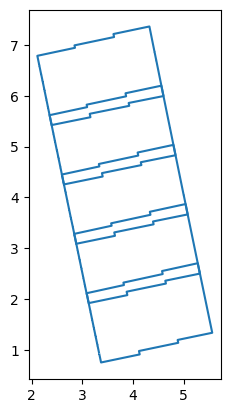

In [18]:
df_frames.iloc[:5].boundary.plot()

(1.9382860499999999, 5.73304295, 0.4226718, 7.6946442)

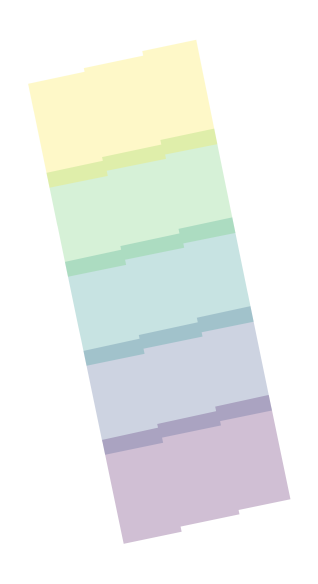

In [19]:
fig, ax = plt.subplots(dpi=150)
df_frames.iloc[:5].plot(column='burst_id_min', alpha=.25, ax=ax)
ax.axis('off')

# Land Intersection

We are going to read a 1 degree buffered land area. This should encompass all land areas relevant for the product. We use this same mask (at full resolution) for the browse imagery.

In [20]:
%%time

df_land = gpd.read_file('usgs_land_1deg_buffered.geojson')    
land_geo = df_land.geometry.unary_union

CPU times: user 2.95 s, sys: 162 ms, total: 3.12 s
Wall time: 535 ms


In [21]:
%%time

# ind_land = df_frames.geometry.intersects(land_geo)

# below replaces the above
# Credit to Scott Staniewicz (@scottstanie)
# Requires shapely>=2.0.0 and python 3.11
from shapely import STRtree

tree = STRtree(df_frames.geometry)
idxs_land = tree.query(land_geo, predicate="intersects")

CPU times: user 1.5 s, sys: 203 ms, total: 1.7 s
Wall time: 1.54 s


In [22]:
df_frames_land = df_frames.iloc[idxs_land].copy()
# Wonky indexing with STRtree
df_frames_land.sort_values(by='OGC_FID_min', inplace=True)
df_frames_land = df_frames_land.reset_index(drop=True)
df_frames_land.head()

,OGC_FID_min,OGC_FID_max,burst_id_min,burst_id_max,relative_orbit_number_min,relative_orbit_number_max,orbit_direction,geometry
0,22,45,8,15,1,1,ASCENDING,"POLYGON Z ((3.08906 2.08797 0.00000, 3.08720 2..."
1,43,66,15,22,1,1,ASCENDING,"POLYGON Z ((2.84448 3.25558 0.00000, 2.84448 3..."
2,64,87,22,29,1,1,ASCENDING,"POLYGON Z ((2.60090 4.42328 0.00000, 2.60090 4..."
3,85,108,29,36,1,1,ASCENDING,"POLYGON Z ((2.35832 5.59108 0.00000, 2.35832 5..."
4,106,129,36,43,1,1,ASCENDING,"POLYGON Z ((2.11654 6.75894 0.00000, 2.11653 6..."


Now that we have the total frames - we are going to assign frame ids.

<AxesSubplot: >

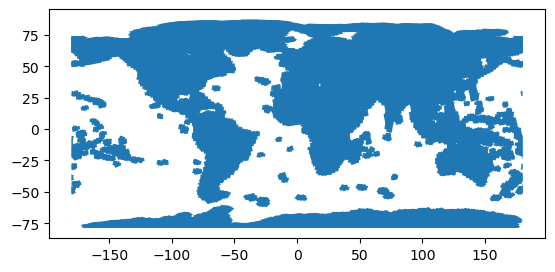

In [23]:
df_frames_land.plot()

In [24]:
df_frames_land = df_frames_land.reset_index(drop=False)
df_frames_land.rename(columns={'index': 'frame_id'}, inplace=True)

(-198.0, 198.00000000000006, -98.8592424, 96.0440904)

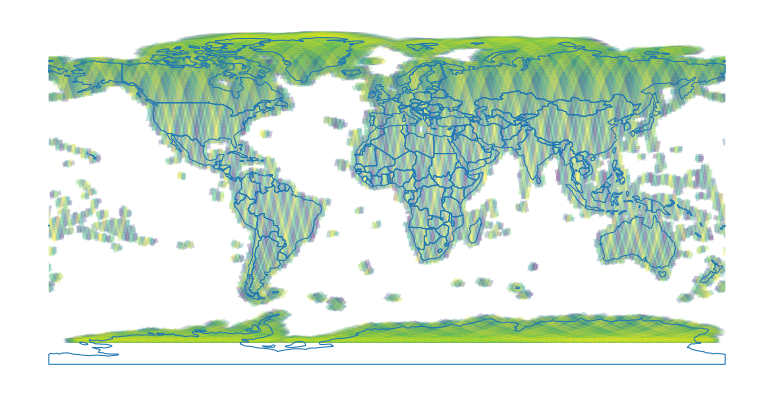

In [25]:
fig, ax = plt.subplots(dpi=150)
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_frames_land.plot(column='burst_id_min', alpha=.25, ax=ax)

df_world.boundary.plot(ax=ax, lw=.5)
ax.axis('off')


# Dateline Fix

We take the multipolygons at the dateline and make sure we have geometries at the left and right hemispheres. This will mean we don't have to take care of this during enumeration of IFGs.

In [26]:
buffer = 5

In [27]:
df_dateline = df_frames_land.cx[:-180 + buffer,:]
df_dateline.head()

,frame_id,OGC_FID_min,OGC_FID_max,burst_id_min,burst_id_max,relative_orbit_number_min,relative_orbit_number_max,orbit_direction,geometry
69,69,1912,1935,638,645,1,1,DESCENDING,"MULTIPOLYGON Z (((-175.54962 71.46220 0.00000,..."
70,70,1933,1956,645,652,1,1,DESCENDING,"MULTIPOLYGON Z (((-176.48376 70.28579 0.00000,..."
71,71,1954,1977,652,659,1,1,DESCENDING,"MULTIPOLYGON Z (((-177.30461 69.15276 0.00000,..."
72,72,1975,1998,659,666,1,1,DESCENDING,"MULTIPOLYGON Z (((-178.05114 68.01650 0.00000,..."
73,73,1996,2019,666,673,1,1,DESCENDING,"MULTIPOLYGON Z (((-178.73944 66.87789 0.00000,..."


In [28]:
multipolygon_index = df_dateline.geometry.map(lambda geo: (geo.geom_type != 'Polygon'))
df_dateline_multi = df_dateline[multipolygon_index].copy()

These plots show how the frames at the dateline are concatentated. There "missing" portion is in the right hemisphere.

(-70.0, 50.0)

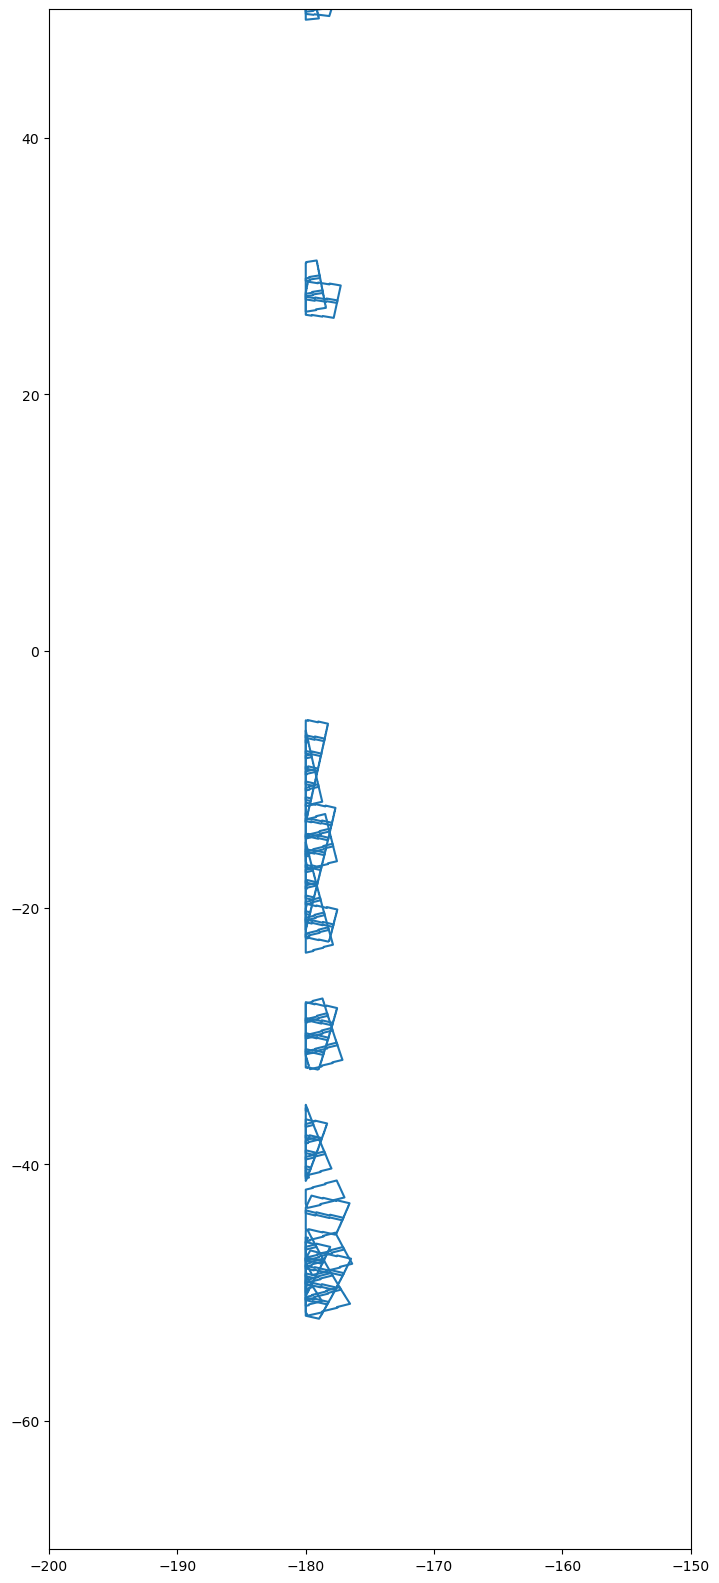

In [29]:
fig, ax = plt.subplots(figsize=(10, 20))
df_dateline_multi.boundary.plot(ax=ax)
ax.set_xlim(-200, -150)
ax.set_ylim(-70, 50)

In [30]:
from dateline import dateline_frame_fix

In [31]:
df_frames_final = dateline_frame_fix(df_frames_land)

/Users/cmarshak/bekaert-team/s1-burst-frames/dateline.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_l = df_dateline_multi.translate(xoff=-360).buffer(1e-7)
/Users/cmarshak/bekaert-team/s1-burst-frames/dateline.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_r = df_dateline_multi.translate(xoff=360).buffer(1e-7)


In [32]:
%load_ext autoreload
%autoreload 2

(-70.0, 50.0)

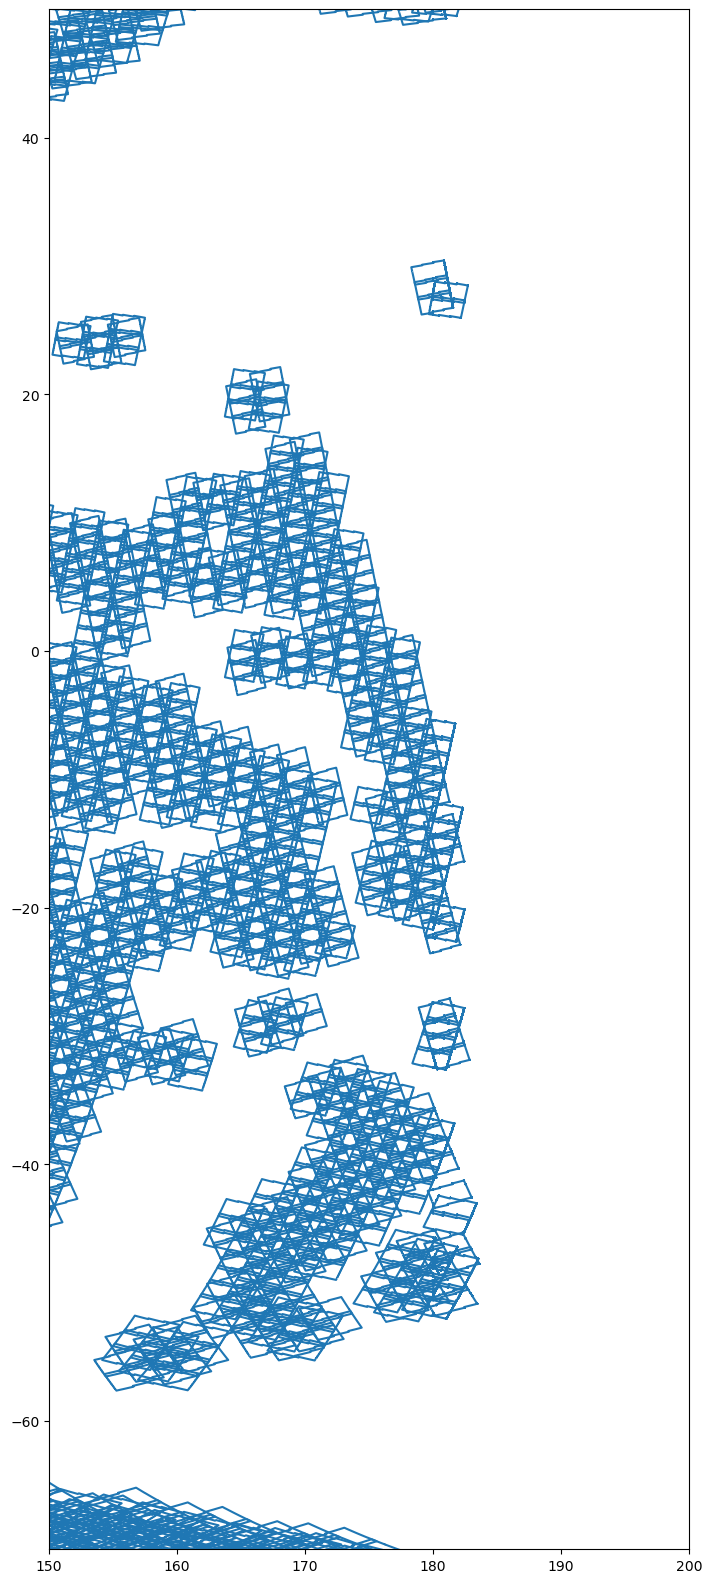

In [34]:
fig, ax = plt.subplots(figsize=(10, 20))

df_frames_final.boundary.plot(ax = ax)
ax.set_xlim(150, 200)
ax.set_ylim(-70, 50)

# Serialization

Uncomment to inspect.

In [36]:
# df_frames_final.to_file('s1-frames.geojson', driver='GeoJSON')

# Compressed serialization

This compresses the geojson into a zip file so it can be included in the package for easily.

In [38]:
from zip_io import to_geojson_zip

to_geojson_zip(df_frames_final, 's1_frames.geojson.zip')

's1_frames.geojson.zip'